First you need to download magicbruhs from hugging face: https://huggingface.co/datasets/osunlp/MagicBrush 
The dataset is massive so feel free to download just the first 50 PARQUET files (as that's all thats used in this example)

In [1]:
import os
import pandas as pd
import pyarrow.parquet as pq
import io
from PIL import Image
import matplotlib.pyplot as plt
import math
import torch
import numpy as np
from torchvision import transforms
from transformers import CLIPModel, AutoProcessor
!pip install lpips
import lpips

base = "/users/aparasel/scratch/magicbrush/downloads" #Set this to ur hugging face download location
n = 2 # ADD IMAGES FROM FIRST N PARQUET FILES
valid_paths = []
for root, _, files in os.walk(base):
    for name in files:
        path = os.path.join(root, name)

        if os.path.getsize(path) < 1024:
            continue
        try:
            pq.ParquetFile(path)      # just to validate
            valid_paths.append(path)
            if len(valid_paths) == n:
                break
        except Exception:
            pass
    if len(valid_paths) == n:
        break

print(f"First {n} parquet-like files:")
for p in valid_paths:
    print(" -", p)

dfs = [pd.read_parquet(p, engine="pyarrow") for p in valid_paths]
df = pd.concat(dfs, ignore_index=True)
print(f"\nLoaded {len(df):,} rows from {len(valid_paths)} files")
print(df.head())


/users/aparasel/.conda/envs/patchscopes-llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First 2 parquet-like files:
 - /users/aparasel/scratch/magicbrush/downloads/0169b0f6ff2278a2962791f8241d0396be45ed103a82990fa14905de3aa67abe
 - /users/aparasel/scratch/magicbrush/downloads/0b09871001c302254de043cfbcc7bc8b2a0b5d36ca9365b8454b951242f2587e

Loaded 345 rows from 2 files
   img_id  turn_index                                         source_img  \
0  551188           1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  551188           2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  551188           3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  165884           1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  165884           2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                            mask_img  \
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  {'bytes': b'\x89PNG\r\n\x1a\n\x0

In [2]:

df_clean = df
t1 = df_clean[df_clean["turn_index"] == 1][["img_id", "source_img", "instruction"]].rename(
    columns={"source_img": "source_img_t1", "instruction": "instruction_t1"}
)
t2 = df_clean[df_clean["turn_index"] == 2][["img_id", "target_img", "instruction"]].rename(
    columns={"target_img": "target_img_t2", "instruction": "instruction_t2"}
)

merged = t1.merge(t2, on="img_id", how="inner")

# Build final output
merged["instruction"] = merged["instruction_t1"] + " and " + merged["instruction_t2"]

result_df = merged[["img_id", "source_img_t1", "target_img_t2", "instruction"]].rename(
    columns={"source_img_t1": "source_img", "target_img_t2": "target_img"}
)

print(result_df.head())
print(f"Size of dataset is {result_df.shape}")

   img_id                                         source_img  \
0  551188  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  165884  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  426370  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  261161  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  309322  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                          target_img  \
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                         instruction  
0  add a guide dog and replace a bag with a yello...  
1  Remove the pears and Turn the bowl into a cutt...  
2  turn the shoes into brown boots and let the bu...  
3  Change the bench to a swingset. and Get rid of...  
4  

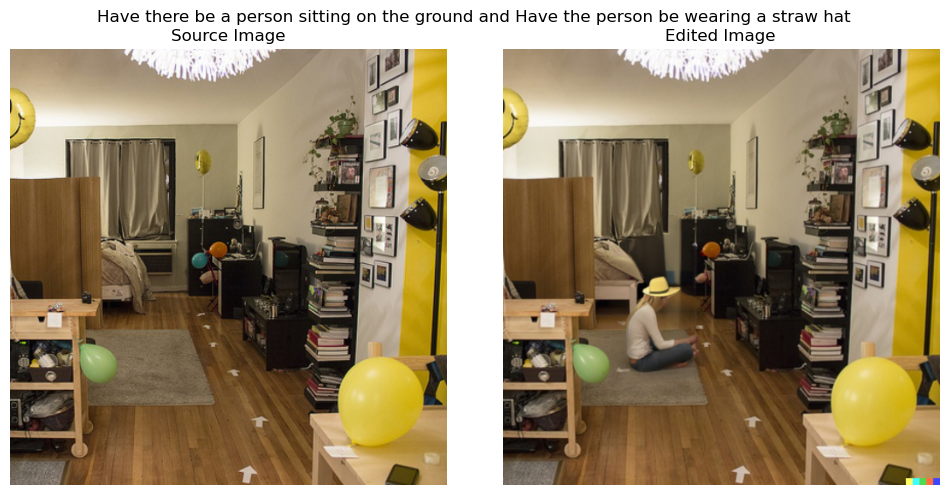

In [3]:
import io
from PIL import Image
import matplotlib.pyplot as plt

row = result_df.iloc[44]

# Decode image bytes
source = Image.open(io.BytesIO(row['source_img']['bytes']))
target = Image.open(io.BytesIO(row['target_img']['bytes']))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(source)
axes[0].set_title("Source Image")
axes[0].axis("off")

axes[1].imshow(target)
axes[1].set_title("Edited Image")
axes[1].axis("off")

plt.suptitle(row['instruction'], wrap=True)
plt.tight_layout()
plt.show()


In [4]:
# =========================
# MagicBrush edit scoring: CLIPScore + DirectionalCLIP + LPIPS
# =========================
# Requirements (once in your env):
#   pip install "transformers>=4.40" lpips torch torchvision pillow



# ------------------------
# Config
# ------------------------
CLIP_MODEL_NAME = "openai/clip-vit-large-patch14"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8                   # adjust for your GPU memory
ALPHA = 3.0                      # for S_pres = exp(-ALPHA * LPIPS)
W_ALIGN, W_DIR, W_PRES = 0.20, 0.70, 0.10   # weights (sum to 1.0 here)
RESIZE_HW = (256, 256)          # common HxW for LPIPS (e.g., 224, 256, 384)

# ------------------------
# Load models
# ------------------------
clip_model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(DEVICE).eval()
clip_proc  = AutoProcessor.from_pretrained(CLIP_MODEL_NAME)

lpips_fn = lpips.LPIPS(net='alex').to(DEVICE).eval()  # fast & robust

# ------------------------
# Utilities
# ------------------------
def dictbytes_to_pil(img_obj):
    # img_obj is like {'bytes': b'...'}
    return Image.open(io.BytesIO(img_obj["bytes"])).convert("RGB")

def clip_embed_images(pil_images):
    with torch.no_grad():
        inputs = clip_proc(images=pil_images, return_tensors="pt")
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        img_feat = clip_model.get_image_features(**inputs)
        img_feat = img_feat / img_feat.norm(p=2, dim=-1, keepdim=True)
    return img_feat  # [B, D], L2-normalized

def clip_embed_text(texts):
    with torch.no_grad():
        inputs = clip_proc(text=texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        txt_feat = clip_model.get_text_features(**inputs)
        txt_feat = txt_feat / txt_feat.norm(p=2, dim=-1, keepdim=True)
    return txt_feat  # [B, D], L2-normalized

def cosine_sim(a, b):
    # a,b are unit vectors
    return (a * b).sum(dim=-1)

def to_01_from_cos(x):
    # map cosine from [-1,1] -> [0,1]
    return (x + 1.0) / 2.0

# For LPIPS we ensure consistent spatial size per batch
to_lpips = transforms.Compose([
    transforms.Resize(RESIZE_HW, interpolation=Image.BICUBIC),
    transforms.ToTensor(),  # [0,1]
])

def pil_to_lpips_tensor(pil_img):
    t = to_lpips(pil_img) * 2.0 - 1.0   # -> [-1,1]
    return t.unsqueeze(0).to(DEVICE)    # [1,3,H,W]

# ------------------------
# Core scoring for one batch
# ------------------------
def score_batch(rows):
    """
    rows: list of (source_pil, target_pil, instruction)
    returns dict of numpy arrays keyed by metrics
    """
    src_imgs = [r[0] for r in rows]
    tgt_imgs = [r[1] for r in rows]
    texts    = [r[2] for r in rows]

    # 1) CLIP embeddings
    img_src_feat = clip_embed_images(src_imgs)
    img_tgt_feat = clip_embed_images(tgt_imgs)
    txt_feat     = clip_embed_text(texts)

    # CLIPScore
    s_align_cos = cosine_sim(img_tgt_feat, txt_feat)         
    s_align     = to_01_from_cos(s_align_cos)              

    # (b) Directional CLIP score
    delta = img_tgt_feat - img_src_feat
    delta = delta / (delta.norm(p=2, dim=-1, keepdim=True) + 1e-8)
    s_dir_cos = cosine_sim(delta, txt_feat)                  
    s_dir     = to_01_from_cos(s_dir_cos)                 

    # 2) Preservation
    src_t = torch.cat([pil_to_lpips_tensor(p) for p in src_imgs], dim=0)  
    tgt_t = torch.cat([pil_to_lpips_tensor(p) for p in tgt_imgs], dim=0)
    with torch.no_grad():
        lp = lpips_fn(src_t, tgt_t)   
    lp = lp.view(-1)                   
    s_pres = torch.exp(-ALPHA * lp)   

    # 3) Final weighted score
    s_final = (W_ALIGN * s_align) + (W_DIR * s_dir) + (W_PRES * s_pres)

    # To CPU numpy
    out = {
        "S_align": s_align.detach().cpu().numpy(),
        "S_dir":   s_dir.detach().cpu().numpy(),
        "LPIPS":   lp.detach().cpu().numpy(),
        "S_pres":  s_pres.detach().cpu().numpy(),
        "S_final": s_final.detach().cpu().numpy(),
    }
    return out


def score_results_df(results_df, max_rows=None, batch_size=BATCH_SIZE):
    df = results_df if max_rows is None else results_df.head(max_rows)

    scores = {k: [] for k in ["S_align", "S_dir", "LPIPS", "S_pres", "S_final"]}
    batch, kept_idx = [], []

    for idx, row in df.iterrows():
        try:
            src_pil = dictbytes_to_pil(row["source_img"])
            tgt_pil = dictbytes_to_pil(row["target_img"])
            text    = str(row["instruction"])
            batch.append((src_pil, tgt_pil, text))
            kept_idx.append(idx)
        except Exception as e:
            print(f"[warn] skipping idx={idx}: {e}")
            continue

        if len(batch) == batch_size:
            out = score_batch(batch)
            for k in scores:
                scores[k].extend(out[k])
            batch, kept_idx = [], []

    if batch:
        out = score_batch(batch)
        for k in scores:
            scores[k].extend(out[k])

    n = len(scores["S_final"])
    df_scored = df.iloc[:n].copy().reset_index(drop=True)
    for k in scores:
        df_scored[k] = scores[k][:n]

    return df_scored




Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/users/aparasel/.conda/envs/patchscopes-llava/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/aparasel/.conda/envs/patchscopes-llava/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /users/aparasel/.conda/envs/patchscopes-llava/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [5]:
df_scored = score_results_df(result_df, max_rows=5000, batch_size=64)
print(df_scored.sort_values("S_final", ascending=False).head(10))

    img_id                                         source_img  \
12   76588  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
51  137690  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
16  237118  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
20   70230  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
86  376085  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
88  137246  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
79  326176  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
56  278550  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
64  294689  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
8   577091  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                           target_img  \
12  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
51  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
16  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
20  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

In [6]:
df_scored

,img_id,source_img,target_img,instruction,S_align,S_dir,LPIPS,S_pres,S_final
0,551188,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,add a guide dog and replace a bag with a yello...,0.605567,0.510710,0.084987,0.774946,0.556105
1,165884,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Remove the pears and Turn the bowl into a cutt...,0.585151,0.448368,0.326215,0.375820,0.468470
2,426370,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,turn the shoes into brown boots and let the bu...,0.612338,0.546866,0.259591,0.458969,0.551170
3,261161,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Change the bench to a swingset. and Get rid of...,0.625495,0.525238,0.308047,0.396873,0.532453
4,309322,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,change 66 to 88 and let the car be red,0.607333,0.552065,0.059976,0.835330,0.591445
...,...,...,...,...,...,...,...,...,...
98,160245,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Could the horse be white? and The building on ...,0.616692,0.525658,0.356003,0.343692,0.525668
99,301381,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,add a person and remove the coffee table,0.585735,0.448028,0.219535,0.517572,0.482524
100,475678,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Get rid of the middle row. and Put stickers on...,0.613784,0.492180,0.199423,0.549762,0.522259
101,417230,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,let the officer cry and change horses to zebras,0.660241,0.577482,0.261290,0.456636,0.581950


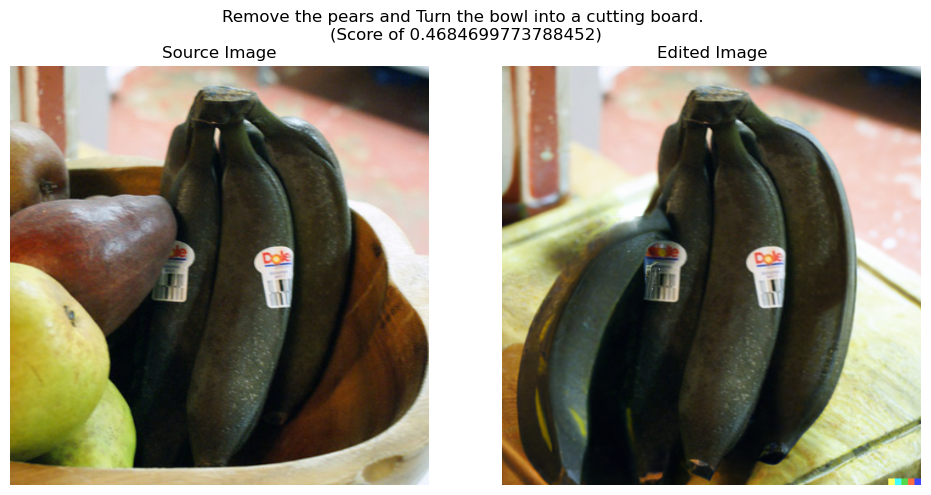

In [7]:

i = 1
row = df_scored.iloc[i]
source = Image.open(io.BytesIO(row['source_img']['bytes']))
target = Image.open(io.BytesIO(row['target_img']['bytes']))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(source)
axes[0].set_title("Source Image")
axes[0].axis("off")

axes[1].imshow(target)
axes[1].set_title("Edited Image")
axes[1].axis("off")

plt.suptitle(str(row['instruction']) + f" \n(Score of {df_scored.iloc[i]['S_final']})", wrap=True)
plt.tight_layout()
plt.show()


In [8]:
filtered_df = df_scored[df_scored['LPIPS'] > 0.11]
filtered_df

,img_id,source_img,target_img,instruction,S_align,S_dir,LPIPS,S_pres,S_final
1,165884,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Remove the pears and Turn the bowl into a cutt...,0.585151,0.448368,0.326215,0.375820,0.468470
2,426370,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,turn the shoes into brown boots and let the bu...,0.612338,0.546866,0.259591,0.458969,0.551170
3,261161,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Change the bench to a swingset. and Get rid of...,0.625495,0.525238,0.308047,0.396873,0.532453
5,411478,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Change the pizza to plain cheese. and Change t...,0.642634,0.523197,0.116843,0.704316,0.565196
6,514217,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,put Jessica Rabbit on the pedestal to the righ...,0.621774,0.556915,0.159688,0.619363,0.576131
...,...,...,...,...,...,...,...,...,...
98,160245,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Could the horse be white? and The building on ...,0.616692,0.525658,0.356003,0.343692,0.525668
99,301381,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,add a person and remove the coffee table,0.585735,0.448028,0.219535,0.517572,0.482524
100,475678,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Get rid of the middle row. and Put stickers on...,0.613784,0.492180,0.199423,0.549762,0.522259
101,417230,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,let the officer cry and change horses to zebras,0.660241,0.577482,0.261290,0.456636,0.581950


In [ ]:
import io
import os
import gc
from PIL import Image
import torch
from diffusers import QwenImageEditPipeline

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

model_path = "ovedrive/qwen-image-edit-4bit"

pipeline = QwenImageEditPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
)

pipeline.enable_model_cpu_offload()

# Extra VRAM savers (suggested from chatGPT)
if hasattr(pipeline, "enable_attention_slicing"):
    pipeline.enable_attention_slicing("max")
if hasattr(pipeline, "vae") and hasattr(pipeline.vae, "enable_slicing"):
    pipeline.vae.enable_slicing()
if hasattr(pipeline, "vae") and hasattr(pipeline.vae, "enable_tiling"):
    pipeline.vae.enable_tiling()

image = Image.open(io.BytesIO(row["source_img"]["bytes"])).convert("RGB")
print("Original size:", image.size)

prompt = "Remove the pears"

inputs = {
    "image": image,
    "prompt": prompt,
    "generator": torch.manual_seed(0),
    "true_cfg_scale": 4.0,
    "negative_prompt": " ",
    "num_inference_steps": 8,   
    "height": 512,
    "width": 512,
}

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

with torch.inference_mode():
    output = pipeline(**inputs)

if torch.cuda.is_available():
    peak = torch.cuda.max_memory_allocated() / 1024**3
    print(f"Peak GPU memory used: {peak:.2f} GB")

output_image = output.images[0]
output_image.save("output_image_edit.png")
print("image saved at", os.path.abspath("output_image_edit.png"))


CUDA available: True
Device: Quadro RTX 6000


Loading pipeline components...: 100%|██████████| 6/6 [01:28<00:00, 14.72s/it]


In [ ]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Tue Nov 11 19:42:25 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 6000                On  | 00000000:3F:00.0 Off |                  Off |
| 48%   64C    P2              98W / 260W |   2029MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--